# 1) Постановка задачи
 В архиве находится 4 csv-файла с данными абонентов. Абоненты поделены на два множества: train (200 абонентов), информация по этим абонентам в файлах train_numbers.csv и train_calls.csv , и test (100 абонентов): файлы test.numbers.csv и test_calls.csv. Файлы train_numbers.csv и test.numbers.csv содержат номера абонентов (ID ключ) обучающей и тестовой выборки соответственно, а также даты рождения абонентов. В файле train_number.csv также есть поле is_true, определяющее, верно заведены паспортные данные абонента (значение is_true = 1) или нет (is_true = 0) Файлы train_calls.csv и test_calls.csv имеют одинаковый формат и содержат историю звонков по обучающей и тестовой выборке. Описание полей файлов следующее:

  *  Number_id - ID абонента (совпадает с ключами из файлов train_numbers.csv и test_numbers.csv).

  *  Call_Date - дата (день). Предоставлена история звонков в промежутке от 10.01.2013 по 31.03.2013.

  *  Part_Date - время суток: 0 означает время суток 0-6ч (ночь), 1 означает 6-12ч (утро), 2 означает 12-18ч (день) и 3 означает 18-24ч (вечер).

  *  Count_Call_In - количество входящих звонков  абоненту, агрегированное по дню Call_Date и времени суток Part_Date.

  *  Count_Call_Out - количество исходящих звонков от абонента, агрегированное по дню Call_Date и времени суток Part_Date.

  *  Count_SMS_In - количество входящих SMS  абоненту, агрегированное по дню Call_Date и времени суток Part_Date.

  *  Count_SMS_Out - количество исходящих SMS от абонента, агрегированное по дню Call_Date и времени суток Part_Date.

  *  All_Duration - суммарная длительность всех звонков за время суток Part_Date и дату Call_Date,в секундах.

  *  Sum_Price - суммарная стоимость всех звонков за время суток Part_Date и дату Call_Date

Требуется построить модель бинарной классификации и предсказать на тестовой выборке, правильная указана дата рождения у абонента или нет. Нам нужно прислать код модели на языке Python (файл .py или ноутбук .ipynb) и файл test_numbers.csv с добавленным полем is_true, сформированным по предсказанию.

In [410]:
from datetime import timedelta
from datetime import datetime
import pandas as pd
import seaborn as sns
from sklearn import  model_selection, linear_model, preprocessing
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
%pylab inline
pd.options.display.max_rows = 200

Populating the interactive namespace from numpy and matplotlib


C:\Users\uraev.DESKTOP-H9FK1LE\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# 2) Время выполнения

In [81]:
Data_start = pd.to_datetime('15.08.2019 18:0:0', format='%d.%m.%Y %H:%M:%S') 
EndDate = Data_start + timedelta(days=5)
print('Начало выполнения ', Data_start)
print('Окончание работы  ', EndDate)

Начало выполнения  2019-08-15 18:00:00
Окончание работы   2019-08-20 18:00:00


# 3) Ход решения

In [637]:
#Загружаем DataSets
train_calls = pd.read_csv('train_calls.csv')
train_numbers = pd.read_csv('train_numbers.csv')

test_calls = pd.read_csv('test_calls.csv')
test_numbers = pd.read_csv('test_numbers.csv')

In [132]:
#Посмотрим на данные
print(train_calls.shape)
train_calls.head(2)

(38153, 9)


,number_id,call_date,part_date,count_call_in,count_call_out,count_sms_in,count_sms_out,all_duration,sum_price
0,237494,13.03.2013,3,3,7,0,6,814,0.96
1,90258,06.03.2013,2,1,0,0,0,91,0.00


In [84]:
print(train_numbers.shape)
train_numbers.head(2)

(200, 3)


,number_id,born_date,is_true
0,53987,17.02.1951,1
1,56010,03.02.1982,0


Объеденим 2 таблицы по общему ключу number_id, используя метод merge

In [133]:
# Соединяем 2 таблицы
DataFrame = train_calls.merge(train_numbers, left_on='number_id', right_on='number_id')
DataFrame.head(2)

,number_id,call_date,part_date,count_call_in,count_call_out,count_sms_in,count_sms_out,all_duration,sum_price,born_date,is_true
0,237494,13.03.2013,3,3,7,0,6,814,0.96,25.01.1979,0
1,237494,30.01.2013,3,2,3,0,1,423,0.13,25.01.1979,0


Оценим визуально статистику и распределения величин при помощи инструмента визуализации данных seaborn

In [75]:
# На вход функция принимает pd.DataFrame первым аргументом, вторым аргументом имя столбца, по которому будут размечены классы.
def seaborn_plot(Data, hue):
    sns.set(style="ticks")
    return (sns.pairplot(Data, hue = hue))

Посмотрим на распределение признаков относительно 2 классов

C:\Users\uraev.DESKTOP-H9FK1LE\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\uraev.DESKTOP-H9FK1LE\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


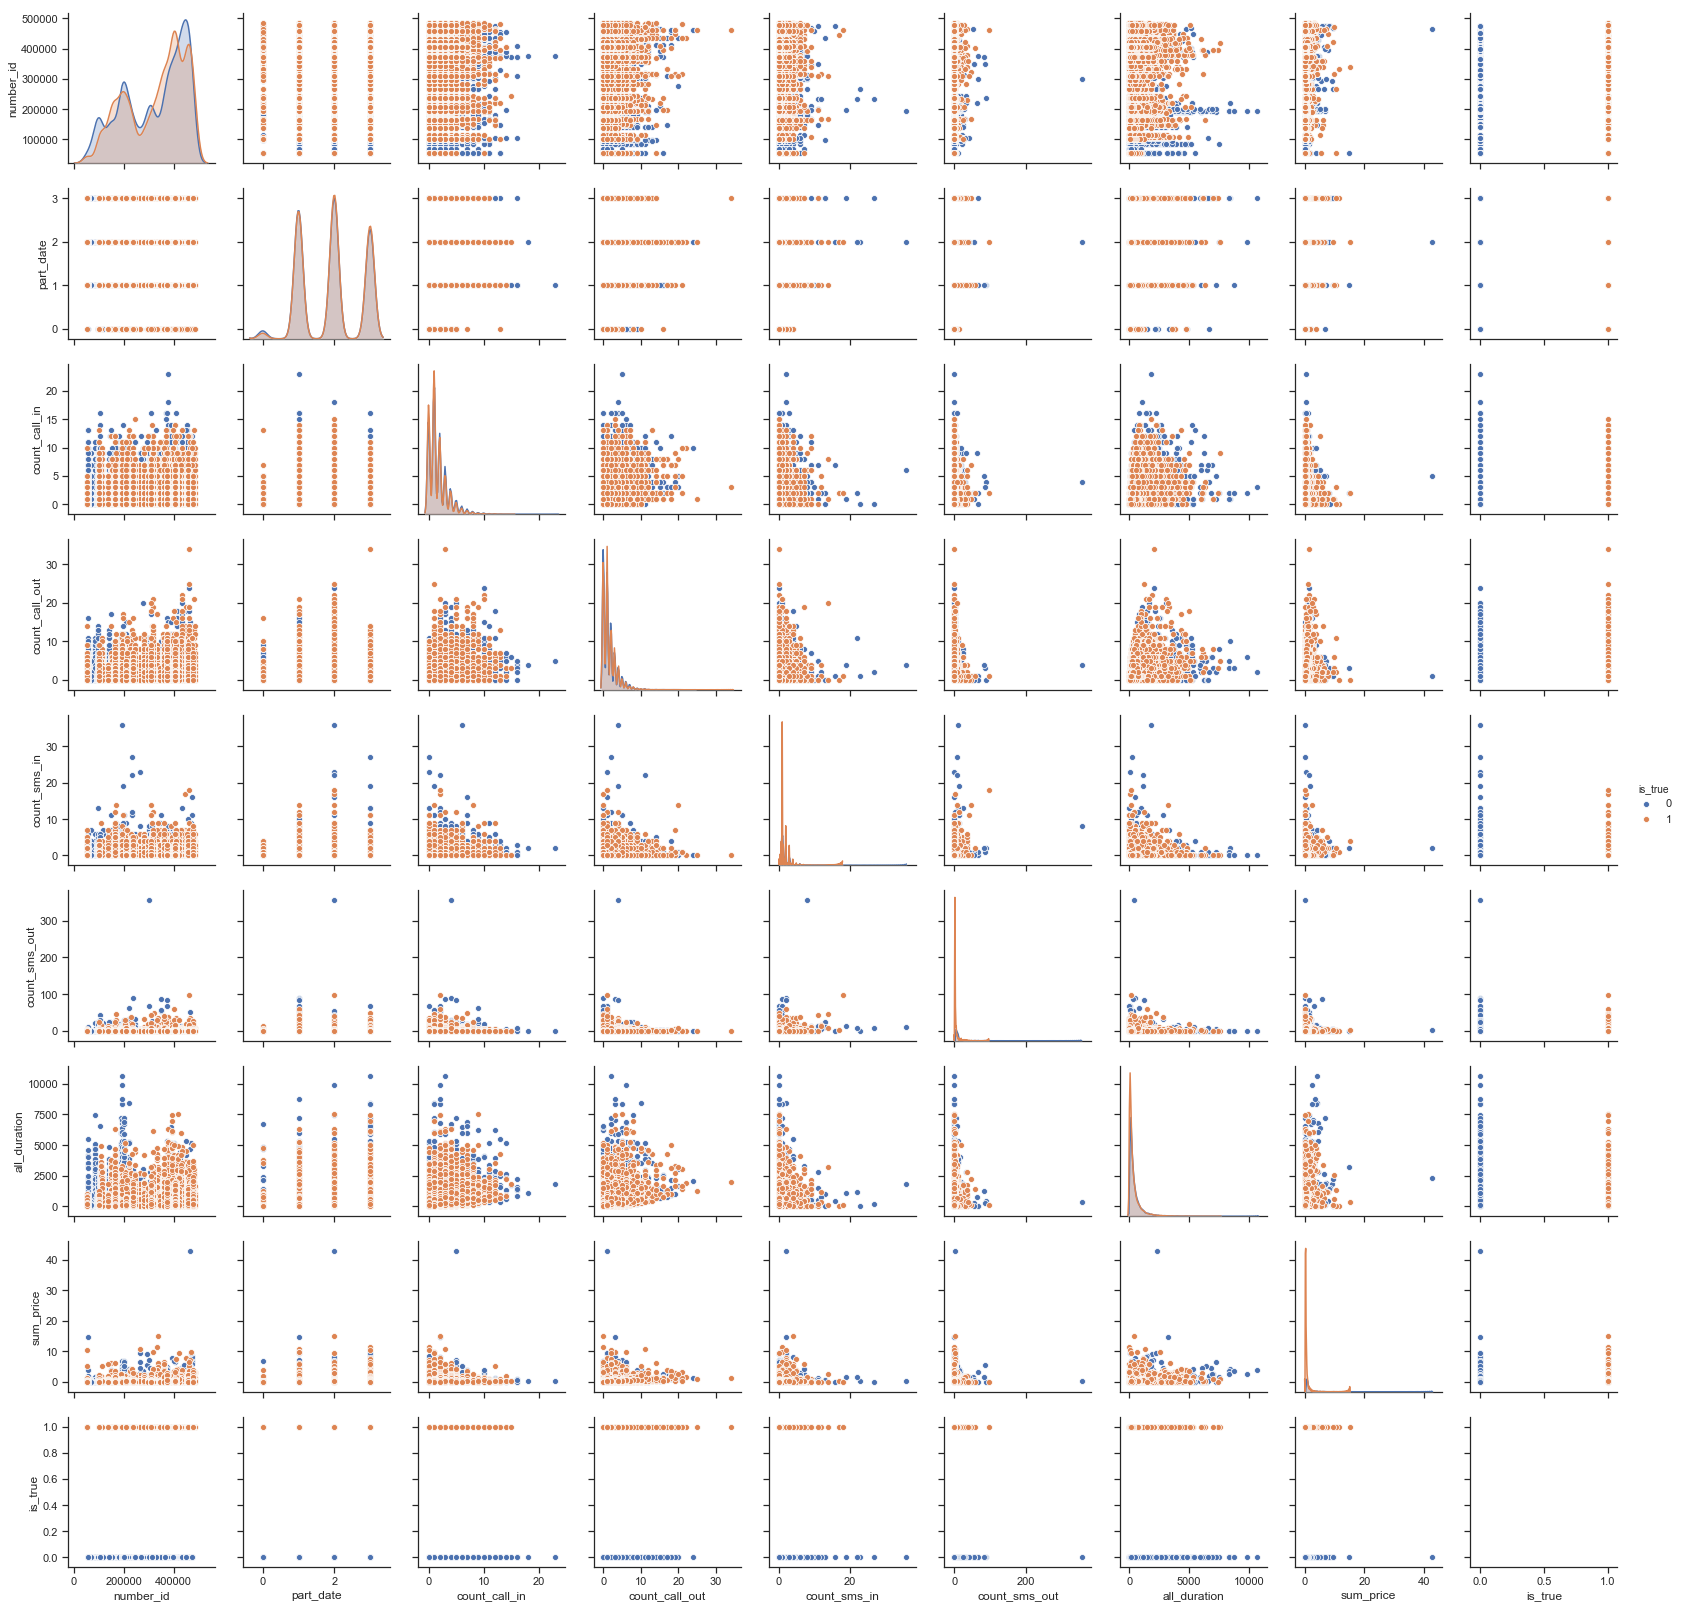

In [50]:
seaborn_plot(DataFrame, 'is_true')

### Судя по полученным распределениям признаков, можно сделать следующие выводы
* 1) В данных имеются выбросы, которые возможно могут повлиять на качество обучения модели(это распределения count_sms_out, count_sms_in,  sum_price и count_call_in) 
* 2) Все признаки исходного DataFrame распределены практически одинаково, это говорит о том, что необходимо добавлять новые, либо преобразовывать имеющиеся данные, чтобы распределения хоть как-то отличались.
* 3) Самый лучший вариант, который сработал, это оставить в этом наборе данных, те объекты, значения полей call_date и born_date которых совпадают по дням и месяцам, собственно после этого преобразования мы получаем 2 разных распределения величин, так как количество входящих звонков у клиентов с верно определёнными датами рождения больше, чем у неверно опреденных.


### Удалим год рождения в признаках call_date born_date, чтобы можно было сравнивать дни и месяцы рождения

In [137]:
DataFrame['call_date'] = DataFrame.call_date.apply(lambda x : '{:%d.%m}'.format(dt.strptime(x, '%d.%m.%Y')))
DataFrame['born_date'] = DataFrame.born_date.apply(lambda x : '{:%d.%m}'.format(dt.strptime(x, '%d.%m.%Y')))

In [75]:
DataFrame.head(2)

,number_id,call_date,part_date,count_call_in,count_call_out,count_sms_in,count_sms_out,all_duration,sum_price,born_date,is_true
0,237494,13.03,3,3,7,0,6,814,0.96,25.01,0
1,237494,30.01,3,2,3,0,1,423,0.13,25.01,0


### Оставим только те объекты, которые имеют одинаковые поля call_date и born_date

In [140]:
DataFrame = DataFrame[(DataFrame['call_date']) == (DataFrame['born_date'])]

In [141]:
DataFrame.head(2)

,number_id,call_date,part_date,count_call_in,count_call_out,count_sms_in,count_sms_out,all_duration,sum_price,born_date,is_true
55,237494,25.01,1,3,4,0,0,338,0.14,25.01,0
64,237494,25.01,3,0,0,0,2,0,0.10,25.01,0


###       Данные каждого объекта в таблице имеют до 4 строк по признаку part_date, интенсивность операций ночью, утром днём и вечером, объеденим это всё в 1 строку, описывающую все операции за сутки.

In [142]:
def sum_operation_days(DataFrame):
    is_true = train_numbers[['is_true', 'number_id']]
    DataFrame.drop(['is_true'], axis=1, inplace=True)
    Data_Frame_mean = DataFrame.groupby(['number_id']).sum()
    Data_Frame_mean.drop(['part_date'], axis = 1, inplace = True)
    Data_Frame_mean = Data_Frame_mean.merge(is_true, left_on='number_id', right_on='number_id')   
    return Data_Frame_mean

In [143]:
DataFrame_sum_day = sum_operation_days(DataFrame)

C:\Users\uraev.DESKTOP-H9FK1LE\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [144]:
DataFrame_sum_day.head(2)

,number_id,count_call_in,count_call_out,count_sms_in,count_sms_out,all_duration,sum_price,is_true
0,53987,17,6,3,0,970,0.38,1
1,67546,2,0,0,0,122,0.00,0


C:\Users\uraev.DESKTOP-H9FK1LE\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\uraev.DESKTOP-H9FK1LE\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


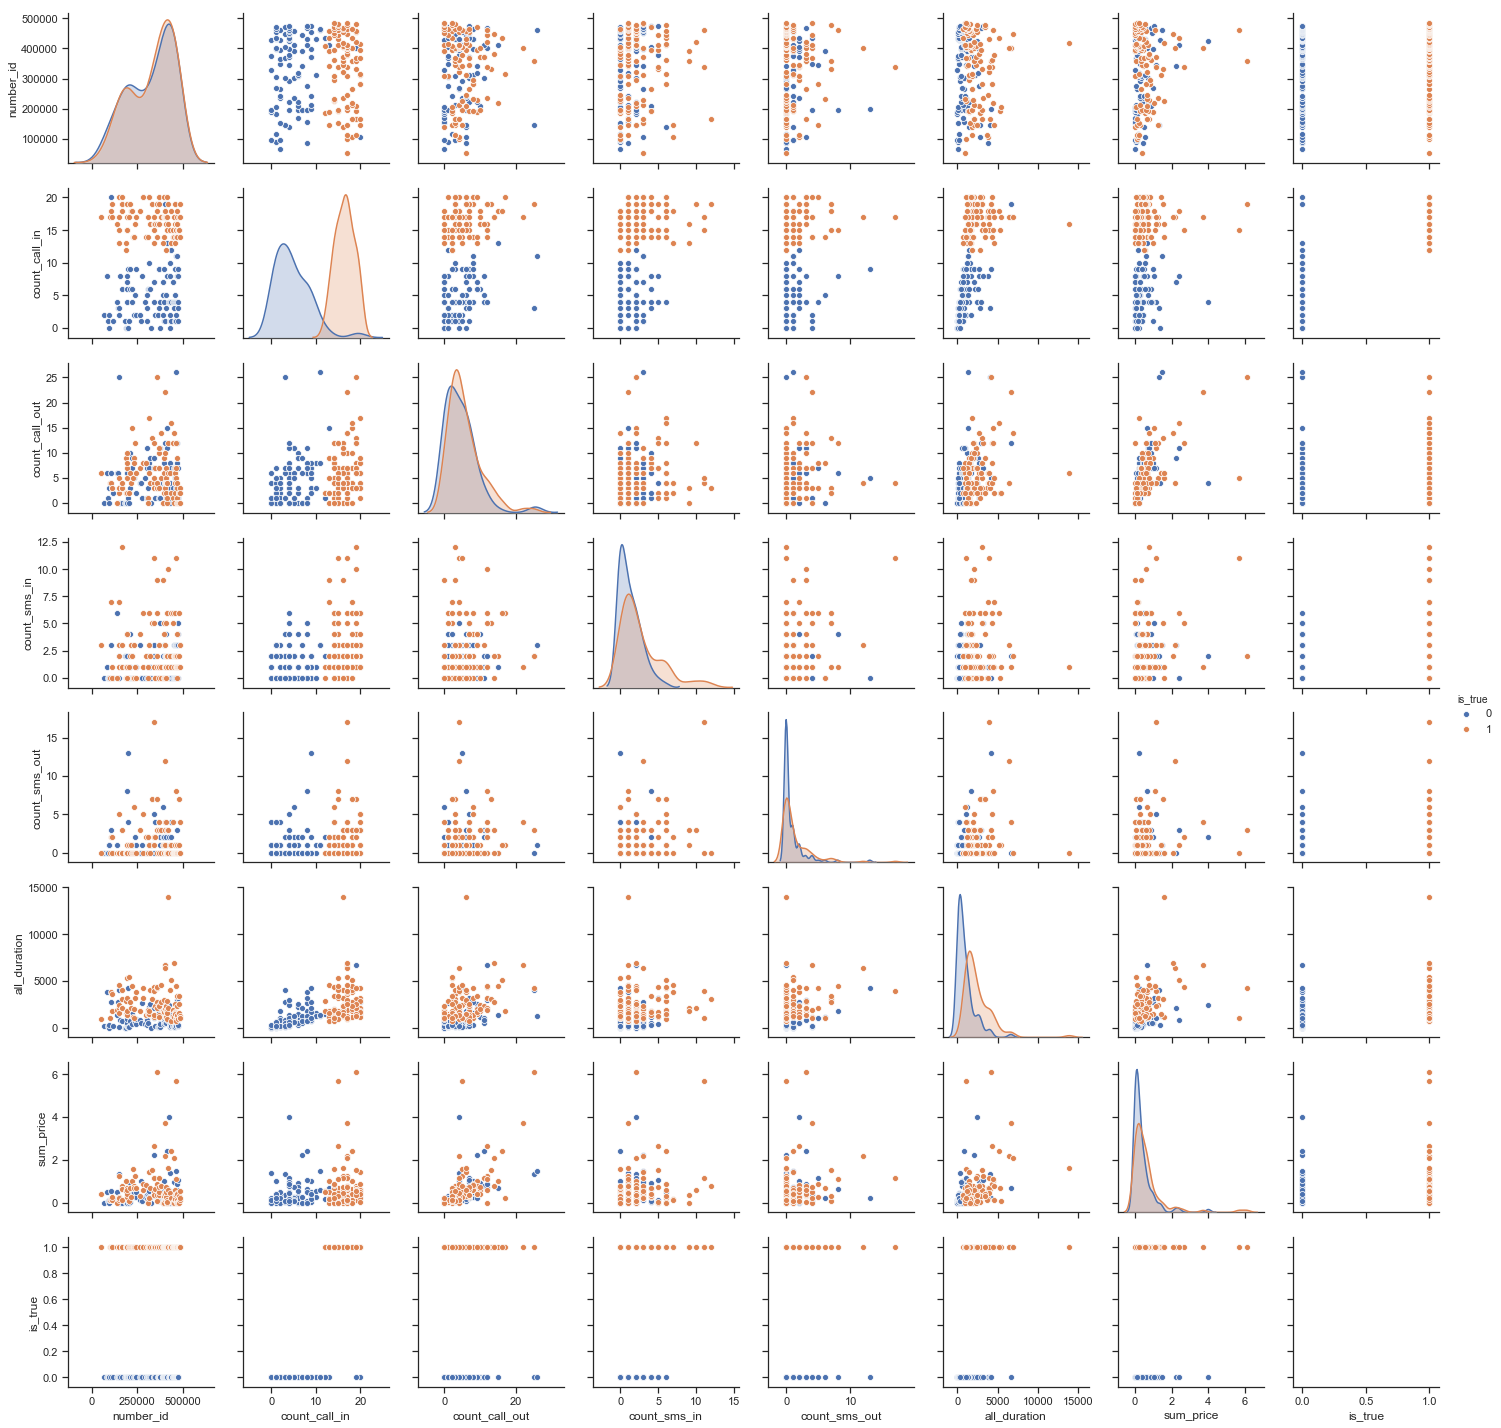

In [145]:
seaborn_plot(DataFrame_sum_day, 'is_true')

### По получившимся распределениям видно, что по входящим звонкам наши классы практически идеально разделяются, теперь обучим модель LogisticRegression

In [435]:
# Определяем признаковое пространство X и целевую метку y
X = DataFrame_sum_day.drop(['number_id', 'is_true'], axis=1, inplace = False).values
y = DataFrame_sum_day['is_true'].values

In [363]:
#Делим данные на обучение и тест в соотношение 70/30
def test_split(X,y):
    return model_selection.train_test_split(X, y, test_size = 0.5,random_state = 1)

### Построим модель с гиперпараметраметрами по умалчанию

In [619]:
#Построим модель с гиперпараметраметрами по умалчанию и посмотрим на её качество на кросс валидации
def build_model(X,y):
    #создание объекта - классификатора
    log_regressor = linear_model.LogisticRegression(random_state = 1,solver= 'liblinear')
    # В качестве стратегии кросс валидации выбрал StratifiedShuffleSplit, так как она позволяет стратифицировать объекты при 
    # разделении по классам, то есть как в обучении, так и в тесте присутствуют объекты обоих классов, n_splits = 10, так как
    # рекомендовано при небольших выборках делать количество фолдов больше.
    cv = model_selection.StratifiedShuffleSplit(n_splits = 10, test_size = 0.5, random_state = 1)
    
    # Долю верных ответов оцениваем по cross_validation, данную метрику можно использовать в задаче, так как классы сбалансированы
    score = model_selection.cross_val_score(log_regressor, X, y, scoring = 'accuracy', cv = cv)
    # усредняем результат cross validation
    print('accuracy_CV = ', mean(score))

In [620]:
build_model(X,y)

accuracy_CV =  0.9397959183673468


### Поделив данные 50/50 на кросс валидации получили качество модели гораздо хуже, чем в соотношении 70/30, попытаемся улучшить качество.

### 1) Данные, подаваемые на обучение не нормализованы. Нормализуем.

In [439]:
pd.DataFrame(X).head(2)

,0,1,2,3,4,5
0,17.0,6.0,3.0,0.0,970.0,0.38
1,2.0,0.0,0.0,0.0,122.0,0.00


In [440]:
# Воспользуемся инструментом библиотеки sklearn для нормализации данных StandardScaler 
X_norm = preprocessing.StandardScaler().fit(X)
X_norm = X_norm.transform(X)
pd.DataFrame(X_norm).head(2)

,0,1,2,3,4,5
0,0.944048,0.181509,0.445577,-0.518389,-0.482395,-0.192821
1,-1.329090,-1.104361,-0.864419,-0.518389,-0.985626,-0.660311


In [621]:
#Обучим модель уже с нормализованными данными
build_model(X_norm,y)

accuracy_CV =  0.9785714285714284


### 2) После нормализации качество алгоритма заметно выросло, теперь попытаемся подобрать гиперпараметры при помощи поиска по сетке(Grid Search). Данный метод не всегда хорош, особенно если использовать более сложные модели, время подбора значительно увеличивается.

In [457]:
# Посмотрим какие гипарпараметры есть у LogisticRegression
?linear_model.LogisticRegression

In [623]:
log_regressor_Greed_search = linear_model.LogisticRegression(random_state = 1, solver= 'liblinear')
cv = model_selection.StratifiedShuffleSplit(n_splits = 10, test_size = 0.5, random_state = 1)

In [624]:
# Инициализируем сетку с набором параметров, которые будут перебираться для определения лучшей комбинации.
# Диапазон значений выбирал исходя из описания и дефолтных параметров модели.
parameters_grid = {
    'tol' : list(np.arange(0.0001, 0.0011, 0.0001)),
    'penalty' : ['l1', 'l2'],
    'C' : list(np.arange(0.5,2.5,0.5)),
    'intercept_scaling' : list(np.arange(1,5,1)),
    'warm_start': ['True', 'False']
}

In [625]:
# Подбор параметров при помощи GridSearchCV
grid_cv = model_selection.GridSearchCV(log_regressor_Greed_search, parameters_grid, scoring = 'accuracy', cv = cv)

In [626]:
%%time
# Обучение сетки
grid_cv.fit(X_norm, y)

Wall time: 16.9 s


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=1, test_size=0.5,
            train_size=None),
       error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=1, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'tol': [0.0001, 0.0002, 0.00030000000000000003, 0.0004, 0.0005, 0.0006000000000000001, 0.0007000000000000001, 0.0008, 0.0009000000000000001, 0.001], 'penalty': ['l1', 'l2'], 'C': [0.5, 1.0, 1.5, 2.0], 'intercept_scaling': [1, 2, 3, 4], 'warm_start': ['True', 'False']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [627]:
#Выведем алгоритм, который показал лучший результат
grid_cv.best_estimator_

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=1, solver='liblinear',
          tol=0.0001, verbose=0, warm_start='True')

In [628]:
# Лучшее качество
print (grid_cv.best_score_)
# Выведем параметры этой модели
print (grid_cv.best_params_)

0.9785714285714285
{'C': 1.0, 'intercept_scaling': 1, 'penalty': 'l2', 'tol': 0.0001, 'warm_start': 'True'}


### Судя по результатам, подбор параметров с лучшими показателями не дал никакого прироста к точности модели.

### 3) Попытаемся отобрать 3 самых важных признака при помощи рекурсивного исключения признаков

In [630]:
from sklearn.feature_selection import RFE
X_norm
Y = y
# feature extraction

model = LogisticRegression(random_state=1, solver= 'liblinear')
# Указываем, сколько признаков хотим отобрать по значимости
rfe = RFE(model, 3)
fit = rfe.fit(X, Y)
#Распределение признаков по значимости
print(fit.ranking_)

[1 1 2 3 4 1]


In [631]:
# Обучим модель на отобранных признаках
X_RFE = DataFrame_sum_day[['count_call_in', 'count_call_out', 'sum_price']].values
X_norm_RFE = preprocessing.StandardScaler().fit(X_RFE)
X_norm_RFE = X_norm_RFE.transform(X_RFE)

In [632]:
build_model(X_norm_RFE,y)

accuracy_CV =  0.9755102040816327


### Качество стало чуть хуже, но, возможно в задаче, где требовалось бы делать упор на скорость обучения модели, это было бы плюсом.

Обучим log_regressor_Greed_search на train_data, чтобы сделать прогноз для тестовых файлов

In [653]:
train_data, test_data, train_labels, test_labels = test_split(X_norm,y)

In [654]:
log_regressor_Greed_search.fit(train_data, train_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=1, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [656]:
print(classification_report(test_labels,log_regressor_Greed_search.predict(test_data) ))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98        48
           1       0.98      0.98      0.98        50

   micro avg       0.98      0.98      0.98        98
   macro avg       0.98      0.98      0.98        98
weighted avg       0.98      0.98      0.98        98



# 4) Теперь сформируем прогноз для тестовых файлов

In [657]:
print(test_calls.shape)
test_calls.head(2)

(18786, 9)


,number_id,call_date,part_date,count_call_in,count_call_out,count_sms_in,count_sms_out,all_duration,sum_price
0,404916,15.03.2013,3,1,0,0,0,33,0.0
1,410097,23.01.2013,1,1,0,0,0,199,0.0


In [658]:
print(test_numbers.shape)
test_numbers.head(2)

(100, 2)


,number_id,born_date
0,100482,22.01.1973
1,101322,27.03.1971


In [659]:
# Соединяем 2 таблицы
DataTest = test_calls.merge(test_numbers, left_on='number_id', right_on='number_id')
DataTest.head(2)

,number_id,call_date,part_date,count_call_in,count_call_out,count_sms_in,count_sms_out,all_duration,sum_price,born_date
0,404916,15.03.2013,3,1,0,0,0,33,0.0,18.02.1973
1,404916,11.01.2013,1,1,1,0,0,235,0.0,18.02.1973


In [660]:
# Исключаем год рождения в полях born_date и call_date
DataTest['call_date'] = DataTest.call_date.apply(lambda x : '{:%d.%m}'.format(dt.strptime(x, '%d.%m.%Y')))
DataTest['born_date'] = DataTest.born_date.apply(lambda x : '{:%d.%m}'.format(dt.strptime(x, '%d.%m.%Y')))
# Оставляем только те объекты у которых поля call_date и born_date совпадают
DataTest = DataTest[(DataTest['call_date']) == (DataTest['born_date'])]

In [661]:
# функция суммирующая операции одного объекта за сутки 
def sum_operation_days_test(DataFrame):
    Data_Frame_mean = DataFrame.groupby(['number_id']).sum()
    Data_Frame_mean.drop(['part_date'], axis = 1, inplace = True)   
    return Data_Frame_mean

In [662]:
Data_test_sum = sum_operation_days_test(DataTest)

In [663]:
# Возникла проблемка с индексом, ниже операции над устранением
Data_test_sum.reset_index(inplace=True)
Data_test_sum.set_index('number_id', drop=False, inplace=True)

In [664]:
Data_test_sum.reset_index(drop=True, inplace=True)

In [665]:
Data_test_sum.head(2)

,number_id,count_call_in,count_call_out,count_sms_in,count_sms_out,all_duration,sum_price
0,100482,17,5,1,3,1911,0.36
1,101322,12,31,2,2,1712,2.07


### Определяем признаковое пространство для прогноза и делаем сам прогноз

In [666]:
# Определяем признаковое пространство
X_test = Data_test_sum.drop(['number_id'], axis=1, inplace = False).values

# Воспользуемся инструментом библиотеки sklearn для нормализации данных StandardScaler 
X_norm_test = preprocessing.StandardScaler().fit(X_test)
X_norm_test = X_norm_test.transform(X_test)
# Делаем прогноз на основании сформированных признаков
y_true = log_regressor_Greed_search.predict(X_norm_test)

In [667]:
# Добавим получившиеся значения в таблицу 
Data_test_sum['is_true'] = y_true

### Формируем новое поле с прогнозом для файла test_numbers

In [669]:
test_numbers = test_numbers.merge(Data_test_sum, left_on='number_id', right_on='number_id')

In [670]:
test_numbers = test_numbers[['number_id', 'born_date', 'is_true' ]]

### Cохраним файл с добавленным полем is_true

In [671]:
test_numbers.to_csv('test_numbers.csv', encoding='utf-8', index=False)

# 5) Выводы по заданию:
Основной задачей было сформировать новое признаковое описание по имеющимся данным, которое позволит разделить 2 класса, чтобы можно было применять какой либо алгоритм классификации. Для решения проблемы использовал следующие варианты преобразований:
* Суммировались все операции абонентов по дням, результата не было;
* Суммировались все операции по конкретным временным интервалам суток, безрезультатно;
* Считался тариф абонентов (sum_price * all_duration) этот способ не позволил разделить клиентов по классам;

Код данных преобразований сюда не стал писать, получилось бы слишком громоздко, он есть отдельно(на всякий слуачай).

Самой лучшей идеей для решения этой задачи было оставить те строки, в которых день и месяц полей call_date и born_data совпадают, данное преобразование признаков позволило идеально разделить классы на 2 распределения по некоторым полям, что позволило добиться качества на по кросс валидации 0.978% accuracy.

Для повышения качества можно было провести следующие действия:
* 1) Протестировать другие классификаторы, например RandomForestClassifier, kNN, SGDClassifier и т.д;
* 2) Удалить предпологаемые выбросы(Тут стоит уже наверное поговорить с прикладным специалистом) скорее всего выбросами являются неверно определённые или перепутанные сотрудниками классы абонентов.
* 3) Увеличить объём обучаемых данных